# Bitcoin volatility and covid's  impact. ¿Is Bitcoin a store of value?

In [1]:
# Importing needed libraries

import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import requests
import datetime as dt
import sys
!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt
!{sys.executable} -m pip install sklearn
from sklearn import linear_model
!{sys.executable} -m pip install statsmodels
import statsmodels.api as sm

# Methods of acquiring the data

As we needed to use at least two methods to get the data, we first tried to gather it using an API (since we just learned how to work with them). But we encountered the problem that the API's about cryptocurrency are mostly pay-to-have. They only let you have the daily data and we needed the historical data to be able to get some conclusions.
Then we decided we were going to use the methods of webscrapping and importing a a few csvs to gather our data.


### Methods :

- Web scraping from CoinMarketcap's website.
- Importing a csv file from YahooFinance to have the historical data of the EUR/USD exchange.
- Importing two csv files about the new confirmed cases and the daily deaths caused by Covid-19.

# 1. Bitcoin volatility vs EUR/USD Exchange volatility

## Defining Bitcoin DataFrame

In [2]:
# Using get protocol and BeautifulSoup library to scrape over the main table of the website.
# Data ranging from 29th of April of 2013 when bitcoin was still not in a trading market but a P2P one.
# Prices and Market Capitalization are displayed using Euros as base value of comparison
url = 'https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130429&end=20200420'
html = requests.get(url).content
html_soup = BeautifulSoup(html, 'html.parser')
bitcoin_data = html_soup.find_all('tr', class_="cmc-table-row")
bitcoin_data_list = []
for element in bitcoin_data:
    lst = element.findAll('td')
    temp_list = []
    for i in lst:
        temp_list.append(i.getText())
    bitcoin_data_list.append(temp_list)


In [3]:
# Setting Date column type to a datetime64 to be able to merge later with the Covid-19 one.
bitcoin_prices_df = pd.DataFrame(bitcoin_data_list, columns=["Date", "Open", "High", "Low", "Close", "Trans_volume", "Market_cap"])
bitcoin_prices_df.Date = bitcoin_prices_df.Date.astype('datetime64')

bitcoin_prices_df

,Date,Open,High,Low,Close,Trans_volume,Market_cap
0,2020-04-21,"6,879.78","6,934.55","6,834.44","6,880.32","32,589,741,511","126,175,238,603"
1,2020-04-20,"7,186.87","7,240.29","6,835.50","6,881.96","37,747,113,936","126,192,239,912"
2,2020-04-19,"7,260.92","7,280.52","7,167.05","7,189.42","31,311,210,215","131,815,853,850"
3,2020-04-18,"7,092.29","7,269.96","7,089.25","7,257.66","32,447,188,386","133,053,136,876"
4,2020-04-17,"7,116.55","7,167.18","7,050.33","7,096.18","32,513,423,567","130,078,472,088"
...,...,...,...,...,...,...,...
2545,2013-05-03,106.25,108.13,79.10,97.75,0,"1,085,995,169"
2546,2013-05-02,116.38,125.60,92.28,105.21,0,"1,168,517,495"
2547,2013-05-01,139.00,139.89,107.72,116.99,0,"1,298,954,594"
2548,2013-04-30,144.00,146.93,134.05,139.00,0,"1,542,813,125"


In [4]:
#Cleaning values of numeric cells to a single separator (to be able to operate with them)
# Using apply, lambda and regex to replace thousand separator commas
bitcoin_prices_df[['Open', 'High', 'Low', 'Close', 'Trans_volume', 'Market_cap']] = bitcoin_prices_df[['Open', 'High',
                'Low', 'Close', 'Trans_volume', 'Market_cap']].apply(lambda x: x.str.replace(',',''))
bitcoin_prices_df.head()

,Date,Open,High,Low,Close,Trans_volume,Market_cap
0,2020-04-21,6879.78,6934.55,6834.44,6880.32,32589741511,126175238603
1,2020-04-20,7186.87,7240.29,6835.50,6881.96,37747113936,126192239912
2,2020-04-19,7260.92,7280.52,7167.05,7189.42,31311210215,131815853850
3,2020-04-18,7092.29,7269.96,7089.25,7257.66,32447188386,133053136876
4,2020-04-17,7116.55,7167.18,7050.33,7096.18,32513423567,130078472088


In [5]:
# Converting the rest of the columns to numeric types
bitcoin_prices_df[['Open', 'High', 'Low', 'Close']] = bitcoin_prices_df[['Open', 'High', 'Low', 
                                                                         'Close']].astype('float64')


bitcoin_prices_df[['Trans_volume', 'Market_cap']] = bitcoin_prices_df[['Trans_volume', 'Market_cap']].astype('int64')

## Importing EUR/DOL Exchange data

In [6]:
eur_dol_ex = pd.read_csv('EURUSD=X.csv')
eur_dol_ex

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-04-22,1.305824,1.308404,1.301800,1.305568,1.305568,0.0
1,2013-04-23,1.305995,1.308216,1.297438,1.306165,1.306165,0.0
2,2013-04-24,1.299376,1.303100,1.296200,1.299444,1.299444,0.0
3,2013-04-25,1.301744,1.309260,1.299326,1.301744,1.301744,0.0
4,2013-04-26,1.300728,1.304631,1.299349,1.300728,1.300728,0.0
...,...,...,...,...,...,...,...
1822,2020-04-15,1.098237,1.098901,1.085765,1.098539,1.098539,0.0
1823,2020-04-16,1.090382,1.090774,1.082966,1.090510,1.090510,0.0
1824,2020-04-17,1.086012,1.089325,1.081268,1.085847,1.085847,0.0
1825,2020-04-20,1.086626,1.089704,1.084305,1.086697,1.086697,0.0


In [7]:
# Transforming date to datetime data type for merging porpuses
eur_dol_ex.Date = eur_dol_ex.Date.astype('datetime64')
eur_dol_ex.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object

## Merging EUR/DOL Exchange and Bitcoin prices dataFrames

In [8]:
#Merging the two first databases
eur_dol_bitcoin_df = pd.merge(eur_dol_ex, bitcoin_prices_df, on='Date')
eur_dol_bitcoin_df.head()

,Date,Open_x,High_x,Low_x,Close_x,Adj Close,Volume,Open_y,High_y,Low_y,Close_y,Trans_volume,Market_cap
0,2013-04-29,1.304291,1.311527,1.303441,1.304257,1.304257,0.0,134.44,147.49,134.00,144.54,0,1603768865
1,2013-04-30,1.309586,1.318600,1.305977,1.309586,1.309586,0.0,144.00,146.93,134.05,139.00,0,1542813125
2,2013-05-01,1.316898,1.324152,1.316205,1.316829,1.316829,0.0,139.00,139.89,107.72,116.99,0,1298954594
3,2013-05-02,1.318218,1.321701,1.304461,1.318218,1.318218,0.0,116.38,125.60,92.28,105.21,0,1168517495
4,2013-05-03,1.306506,1.315097,1.303747,1.306506,1.306506,0.0,106.25,108.13,79.10,97.75,0,1085995169


In [9]:
## Cleaning data of merged 
eur_dol_bitcoin_df = eur_dol_bitcoin_df.drop(columns=['Volume', 'Adj Close'], axis=1)
eur_dol_bitcoin_df.head()

,Date,Open_x,High_x,Low_x,Close_x,Open_y,High_y,Low_y,Close_y,Trans_volume,Market_cap
0,2013-04-29,1.304291,1.311527,1.303441,1.304257,134.44,147.49,134.00,144.54,0,1603768865
1,2013-04-30,1.309586,1.318600,1.305977,1.309586,144.00,146.93,134.05,139.00,0,1542813125
2,2013-05-01,1.316898,1.324152,1.316205,1.316829,139.00,139.89,107.72,116.99,0,1298954594
3,2013-05-02,1.318218,1.321701,1.304461,1.318218,116.38,125.60,92.28,105.21,0,1168517495
4,2013-05-03,1.306506,1.315097,1.303747,1.306506,106.25,108.13,79.10,97.75,0,1085995169


In [10]:
#renaming all columns to make the df more understandable
eur_dol_bitcoin_df = eur_dol_bitcoin_df.rename(columns={'Open_x':'Open_EUR_USD','High_x':'High_EUR_USD', 'Low_x':'Low_EUR_USD',
                                  'Close_x':'Close_EUR_USD','Open_y':'Open_BTC_EUR','High_y':'High_BTC_EUR',
                                   'Low_y':'Low_BTC_EUR','Close_y':'Close_BTC_EUR', 'Trans_volume': 'Volume_BTC_EUR',
                                  'Market_cap': 'Market_cap_BTC_EUR'})

In [11]:
# Creating USD/EUR Column bydoing the invers of the EUR/USD exchange
eur_dol_bitcoin_df['Close_USD_EUR'] = (1 / eur_dol_bitcoin_df.Close_EUR_USD)
eur_dol_bitcoin_df

,Date,Open_EUR_USD,High_EUR_USD,Low_EUR_USD,Close_EUR_USD,Open_BTC_EUR,High_BTC_EUR,Low_BTC_EUR,Close_BTC_EUR,Volume_BTC_EUR,Market_cap_BTC_EUR,Close_USD_EUR
0,2013-04-29,1.304291,1.311527,1.303441,1.304257,134.44,147.49,134.00,144.54,0,1603768865,0.766720
1,2013-04-30,1.309586,1.318600,1.305977,1.309586,144.00,146.93,134.05,139.00,0,1542813125,0.763600
2,2013-05-01,1.316898,1.324152,1.316205,1.316829,139.00,139.89,107.72,116.99,0,1298954594,0.759400
3,2013-05-02,1.318218,1.321701,1.304461,1.318218,116.38,125.60,92.28,105.21,0,1168517495,0.758600
4,2013-05-03,1.306506,1.315097,1.303747,1.306506,106.25,108.13,79.10,97.75,0,1085995169,0.765400
...,...,...,...,...,...,...,...,...,...,...,...,...
1817,2020-04-15,1.098237,1.098901,1.085765,1.098539,6845.56,6928.66,6633.40,6642.11,32288311031,121731940639,0.910300
1818,2020-04-16,1.090382,1.090774,1.082966,1.090510,6640.45,7134.45,6555.50,7116.80,46783242377,130445413270,0.917002
1819,2020-04-17,1.086012,1.089325,1.081268,1.085847,7116.55,7167.18,7050.33,7096.18,32513423567,130078472088,0.920940
1820,2020-04-20,1.086626,1.089704,1.084305,1.086697,7186.87,7240.29,6835.50,6881.96,37747113936,126192239912,0.920220


## Comparison of price Volatility

### Volatility by standard deviation from 29 of April of 2013. 

In [12]:
## Using describe to get statistic comparison
eur_dol_bitcoin_df.describe()

,Open_EUR_USD,High_EUR_USD,Low_EUR_USD,Close_EUR_USD,Open_BTC_EUR,High_BTC_EUR,Low_BTC_EUR,Close_BTC_EUR,Volume_BTC_EUR,Market_cap_BTC_EUR,Close_USD_EUR
count,1818.000000,1818.000000,1818.000000,1818.000000,1822.000000,1822.000000,1822.000000,1822.000000,1.822000e+03,1.822000e+03,1818.000000
mean,1.176771,1.180415,1.173037,1.176787,3284.204764,3375.598068,3183.896894,3286.918101,5.410143e+09,5.639635e+10,0.855182
std,0.096892,0.096703,0.097004,0.096888,3835.518429,3958.150496,3691.611827,3836.584801,9.938511e+09,6.735151e+10,0.065893
min,1.039393,1.041992,1.034768,1.039047,76.000000,78.300000,65.530000,68.430000,0.000000e+00,7.784112e+08,0.717830
25%,1.108931,1.111999,1.106085,1.108985,387.520000,396.937500,376.670000,386.497500,2.543598e+07,5.509473e+09,0.810475
50%,1.135937,1.139277,1.132403,1.135989,781.925000,815.245000,770.315000,783.230000,1.115555e+08,1.143453e+10,0.880290
75%,1.233806,1.239111,1.230043,1.233845,6497.255000,6609.790000,6396.640000,6500.902500,5.747323e+09,1.125566e+11,0.901725
max,1.392990,1.399110,1.391260,1.393088,19118.300000,19371.000000,18355.900000,19114.200000,7.415677e+10,3.201743e+11,0.962420


In [13]:
std_differences = abs(eur_dol_bitcoin_df.Close_USD_EUR.std() - eur_dol_bitcoin_df.Close_BTC_EUR.std())
print('The difference of standard deviations is: ', std_differences)

The difference of standard deviations is:  3836.5189084206904


Since Bitcoin launched we can se it's standard deviation is huge. In comparison with the Standard Deviation for prices of the USD/EUR Exchange we can se the BTC-EUR volatility is 3836.616782763622 times higher than the USD/EUR for the same time period.

## Price volatility plots

Text(0, 0.5, 'Euros')

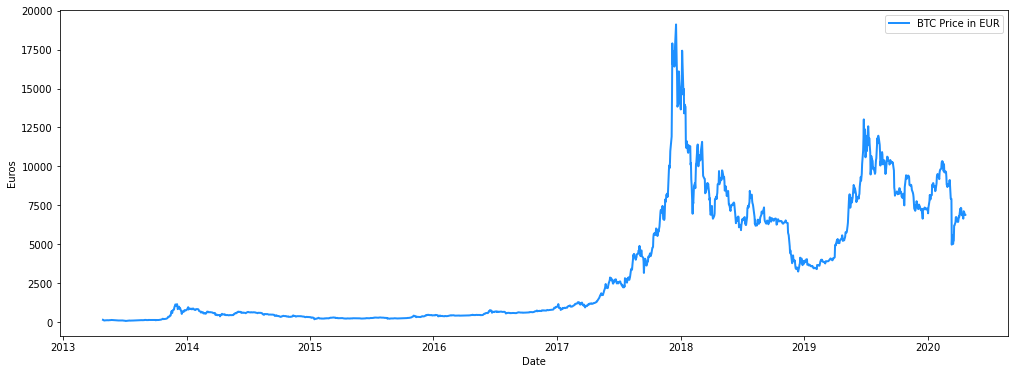

In [14]:
#Ploting the variability of Bitcoin prices from its origin to nowadays
x = eur_dol_bitcoin_df.Date
y = eur_dol_bitcoin_df.Close_BTC_EUR
plt.figure(figsize=(17,6))

plt.plot(x, y, 'dodgerblue', label='BTC Price in EUR', 
         linewidth=2)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Euros')

By the figure above we can se there's a huge distance between the prices. From 2013 to 2017 it kept rather stable, but after 2017 (december of that year was the moment Bitcoin started its exchange market) we see an exponential surge and then the data is highly variable.

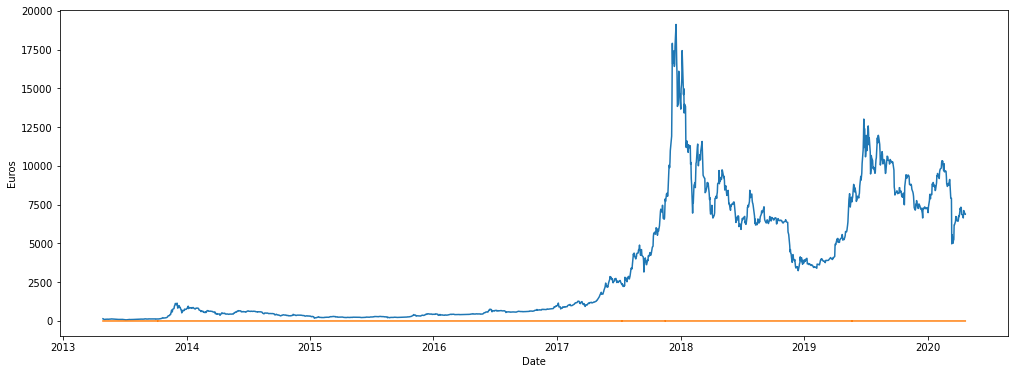

In [15]:
# Plotting a comparison between BTC/EUR and USD/EUR exchange
plt.figure(figsize=(17,6))
plt.plot(eur_dol_bitcoin_df.Date, eur_dol_bitcoin_df.Close_BTC_EUR, label='BTC/EUR')
plt.xlabel('Date')
plt.ylabel('Euros')
plt.plot(eur_dol_bitcoin_df.Date, eur_dol_bitcoin_df.Close_USD_EUR, label='USD/EUR')


Historically the USD/EUR price has been stable and we can see it keeps its behaviour as a store of value. While for bitcoin the data is inconclusive to tell if we can consider it as a store of value. At first sight we can't conclude that it's a store of value because the volatility is higher than the USD/EUR one, but we also know not all fiat currencies are as stable as this exchange.

### YTD Volatility 

In [16]:
# Filtering by date. (Only market days counted)
YTD_BTC_EUR_USD = eur_dol_bitcoin_df[(eur_dol_bitcoin_df['Date'] > '2019-04-20') & 
                                     (eur_dol_bitcoin_df['Date'] < '2020-04-20')]
YTD_BTC_EUR_USD

,Date,Open_EUR_USD,High_EUR_USD,Low_EUR_USD,Close_EUR_USD,Open_BTC_EUR,High_BTC_EUR,Low_BTC_EUR,Close_BTC_EUR,Volume_BTC_EUR,Market_cap_BTC_EUR,Close_USD_EUR
1560,2019-04-22,1.124455,1.126380,1.123671,1.124455,5312.49,5422.69,5280.28,5399.37,14601631648,95354207776,0.889320
1561,2019-04-23,1.125885,1.126126,1.119344,1.125898,5399.37,5633.80,5389.41,5572.36,15867308108,98417387004,0.888180
1562,2019-04-24,1.122448,1.122460,1.118306,1.122435,5571.51,5642.04,5418.26,5464.87,17048033399,96530038144,0.890920
1563,2019-04-25,1.115698,1.116400,1.112174,1.115349,5466.52,5542.24,5181.34,5210.52,15330283408,92046492864,0.896580
1564,2019-04-26,1.113710,1.117281,1.112298,1.113685,5210.30,5383.63,5177.37,5279.35,16812108040,93272287960,0.897920
...,...,...,...,...,...,...,...,...,...,...,...,...
1815,2020-04-13,1.093135,1.096852,1.089360,1.093267,6965.62,6965.62,6668.26,6845.04,38619308647,125422221237,0.914690
1816,2020-04-14,1.091953,1.098394,1.091572,1.092299,6843.28,6958.56,6793.82,6842.43,34110434052,125388687977,0.915500
1817,2020-04-15,1.098237,1.098901,1.085765,1.098539,6845.56,6928.66,6633.40,6642.11,32288311031,121731940639,0.910300
1818,2020-04-16,1.090382,1.090774,1.082966,1.090510,6640.45,7134.45,6555.50,7116.80,46783242377,130445413270,0.917002


In [17]:
# Getting basic statistics
YTD_BTC_EUR_USD.describe()

,Open_EUR_USD,High_EUR_USD,Low_EUR_USD,Close_EUR_USD,Open_BTC_EUR,High_BTC_EUR,Low_BTC_EUR,Close_BTC_EUR,Volume_BTC_EUR,Market_cap_BTC_EUR,Close_USD_EUR
count,259.000000,259.000000,259.000000,259.000000,260.000000,260.000000,260.000000,260.000000,2.600000e+02,2.600000e+02,259.000000
mean,1.109802,1.112422,1.106802,1.109851,8601.377269,8809.847308,8378.708269,8612.432192,2.595568e+10,1.549402e+11,0.901152
std,0.013358,0.013001,0.013740,0.013341,1657.872455,1700.411505,1606.605664,1660.725774,1.062826e+10,2.943488e+10,0.010888
min,1.065848,1.080847,1.065451,1.065735,5002.580000,5311.270000,4106.980000,4970.790000,1.312571e+10,9.080461e+10,0.877170
25%,1.102141,1.104209,1.099330,1.102013,7407.120000,7545.195000,7231.850000,7341.450000,1.753159e+10,1.332651e+11,0.893725
50%,1.110248,1.112223,1.107788,1.110371,8585.270000,8726.325000,8300.155000,8580.485000,2.283057e+10,1.535369e+11,0.900600
75%,1.118843,1.121825,1.116507,1.118912,9820.797500,10100.362500,9611.992500,9799.937500,3.209567e+10,1.765857e+11,0.907430
max,1.140017,1.149584,1.137838,1.140030,13017.120000,13796.490000,12233.260000,13016.230000,7.415677e+10,2.314621e+11,0.938320


From the data above we see that a YTD comparison for April 2019 to April 2020 has made the difference in the standard deviations reduced. Although the split is still quite impressive. With this data we can conclude that Bitcoin prices are indeed quite unstable, especially if we compare them with the price surges and lows from a fiat currency exchange, that for EUR/USD makes more than 60% of the transactions of FX market. 
[[1]](https://en.wikipedia.org/wiki/Foreign_exchange_market)

## Price Histogram

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'BTC Price distribution in EUR YTD Analysis')

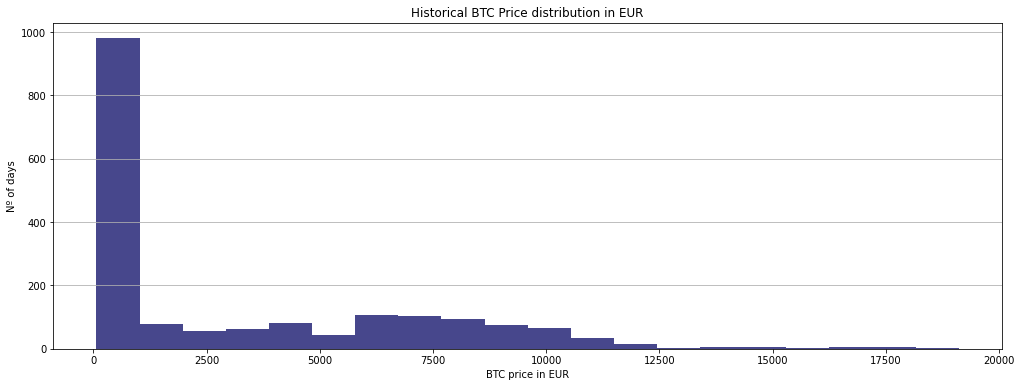

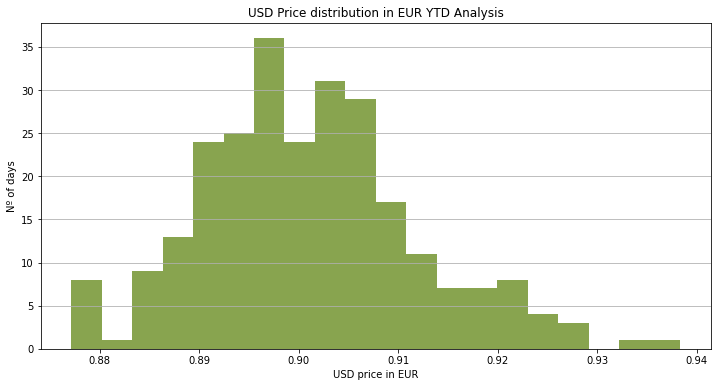

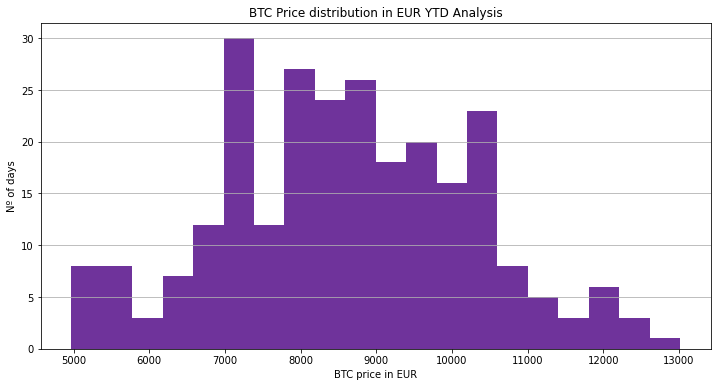

In [18]:
#Plotting Historical prices for BTC/EUR histogram
plt.figure(figsize=(17,6))
plt.hist(eur_dol_bitcoin_df.Close_BTC_EUR,
         bins=20,
         histtype='bar',
         color='midnightblue',
         alpha=0.8)
plt.grid(axis='y')
plt.xlabel('BTC price in EUR')
plt.ylabel('Nº of days')
plt.title('Historical BTC Price distribution in EUR')

#Plotting YTD BTC/EUR price histogram

plt.figure(figsize=(12,6))
plt.hist(YTD_BTC_EUR_USD.Close_USD_EUR,
         bins=20,
         histtype='bar',
         color='olivedrab',
         alpha=0.8)
plt.grid(axis='y')
plt.xlabel('USD price in EUR')
plt.ylabel('Nº of days')
plt.title('USD Price distribution in EUR YTD Analysis')

#Plotting YTD USD/EUR price histogram

plt.figure(figsize=(12,6))
plt.hist(YTD_BTC_EUR_USD.Close_BTC_EUR,
         bins=20,
         histtype='bar',
         color='indigo',
         alpha=0.8)
plt.grid(axis='y')
plt.xlabel('BTC price in EUR')
plt.ylabel('Nº of days')
plt.title('BTC Price distribution in EUR YTD Analysis')


If we take the whole lifetime of bitcoin (first plot) we can't say much about its histogram because for the most of it it wasn't in the markets and it's price was to close to 0 for so many days it's difficult to get conclusions out of it.
But if we check the second and third plots we can see that the behavior of bitcoin and the EUR/USD exchanges are pretty similar (in relative terms because the absolute variation is still much higher with Bitcoin) and this can tell us that the value for bitcoin is stabilizing and it's starting to look normally distributed as the EUR/USD is. Therefore, we can start seeing why some people would use it as a store of value (not for a European yet, but if you countries currency is a more volatile one it could be a good option to go for).

## YTD BTC/EUR vs YTD USD/EUR

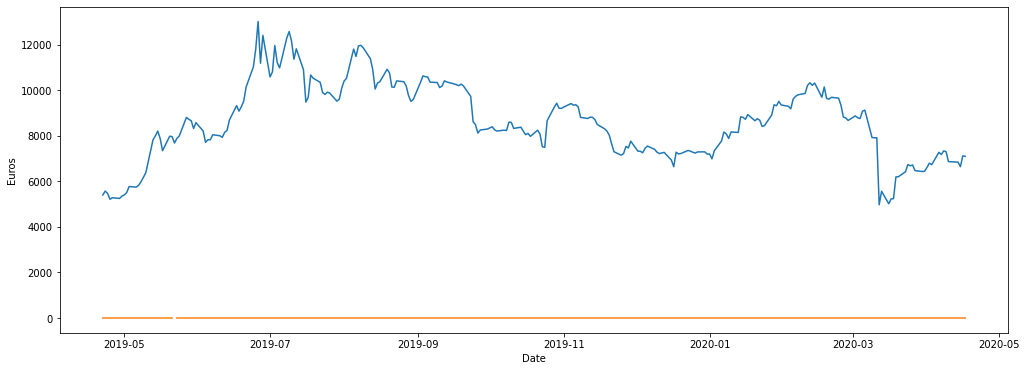

In [19]:
plt.figure(figsize=(17,6))
plt.plot(YTD_BTC_EUR_USD.Date, YTD_BTC_EUR_USD.Close_BTC_EUR, label='BTC/EUR')
plt.xlabel('Date')
plt.ylabel('Euros')
plt.plot(YTD_BTC_EUR_USD.Date, YTD_BTC_EUR_USD.Close_USD_EUR, label='USD/EUR')

In this plot we can see that even though Bitcoin volatility has descreased by half over the years it is still much more votatile than the EUR/USD exchange (arguably he most stable fiat exchange).

# 2. Coronavirus impact on prices and its volatilities

## Global Confirmed Corona Cases

In [20]:
# Reading the csv for confirmed Covid-19 cases
df = pd.read_csv('time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,521,555,607,665,714,784,840,906,933,996
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,416,433,446,467,475,494,518,539,548,562
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,601,601,638,646,659,673,673,696,704,713
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,19,19,19,24,24


In [21]:
# Selecting the desired rows for EU countries and USA
data_EU_US = df[df['Country/Region'].isin(['Andorra', 'Albania', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
                                          'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 
                                          'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Liechtenstein',
                                          'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands',
                                          'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino',
                                          'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'Ukraine',
                                          'United Kingdom', 'US'])]
data_EU_US

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,416,433,446,467,475,494,518,539,548,562
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,601,601,638,646,659,673,673,696,704,713
16,NaN,Austria,47.5162,14.5501,0,0,0,0,0,0,...,13555,13806,13945,14041,14226,14336,14476,14595,14671,14749
22,NaN,Belarus,53.7098,27.9534,0,0,0,0,0,0,...,1981,2226,2578,2919,3281,3728,4204,4779,4779,4779
23,NaN,Belgium,50.8333,4.0000,0,0,0,0,0,0,...,26667,28018,29647,30589,31119,33573,34809,36138,37183,38496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,British Virgin Islands,United Kingdom,18.4207,-64.6400,0,0,0,0,0,0,...,3,3,3,3,3,3,3,4,4,4
251,Turks and Caicos Islands,United Kingdom,21.6940,-71.7979,0,0,0,0,0,0,...,8,8,9,10,10,10,11,11,11,11
256,"Bonaire, Sint Eustatius and Saba",Netherlands,12.1784,-68.2385,0,0,0,0,0,0,...,2,2,3,3,3,3,3,3,3,5
258,Falkland Islands (Malvinas),United Kingdom,-51.7963,-59.5236,0,0,0,0,0,0,...,5,5,5,5,11,11,11,11,11,11


In [22]:
# Cleaning data: deleting provinces, reset index and deleting index column
df_countries_only = data_EU_US[data_EU_US['Province/State'].isna()]
data_clean = df_countries_only.drop(['Province/State'], axis=1)
df_good = data_clean.reset_index()
del df_good['index']

In [23]:
# Cleaning part 2: Dropping latitue and longitude. 
df_good = df_good.drop(columns=['Lat', 'Long']).set_index("Country/Region")
# Transposing to get a proper time series
df_good = df_good.T.reset_index()
df_good = df_good.rename(columns={'index':'Date'})
# Converting to datetime data type
df_good.Date = df_good.Date.astype('datetime64')


In [24]:
# Creating Eurozone column with the sum of all countries using the EURO currency
df_good['Eurozone'] = (df_good['Andorra'] + df_good['Austria'] + df_good['Belgium'] + df_good['Cyprus'] + 
                       df_good['Estonia'] + df_good['Finland'] + df_good['France'] + df_good['Germany'] + 
                       df_good['Greece'] + df_good['Ireland'] + df_good['Italy'] + df_good['Latvia'] + 
                       df_good['Liechtenstein'] + df_good['Lithuania'] + df_good['Luxembourg'] + 
                       df_good['Malta'] + df_good['Monaco'] + df_good['Montenegro'] + 
                       df_good['Netherlands'] + df_good['Portugal'] + df_good['San Marino'] +
                       df_good['Slovakia'] + df_good['Slovenia'] + df_good['Spain'])
df_good

Country/Region,Date,Albania,Andorra,Austria,Belarus,Belgium,Bosnia and Herzegovina,Bulgaria,Croatia,Cyprus,...,Slovakia,Slovenia,Spain,Sweden,Switzerland,Turkey,Ukraine,United Kingdom,US,Eurozone
0,2020-01-22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2020-01-23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2020-01-24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
3,2020-01-25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,3
4,2020-01-26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2020-04-15,494,673,14336,3728,33573,1110,747,1741,715,...,863,1248,177644,11927,26336,69392,3764,98476,636350,734411
85,2020-04-16,518,673,14476,4204,34809,1167,800,1791,735,...,977,1268,184948,12540,26732,74193,4161,103093,667592,765381
86,2020-04-17,539,696,14595,4779,36138,1214,846,1814,750,...,1049,1304,190839,13216,27078,78546,4662,108692,699706,784438
87,2020-04-18,548,704,14671,4779,37183,1268,878,1832,761,...,1089,1317,191726,13822,27404,82329,5106,114217,732197,794996


In [25]:
#keeping the columns that we are interested in
confirmed_final = df_good[['Date','US','Eurozone' ]]
confirmed_final


Country/Region,Date,US,Eurozone
0,2020-01-22,1,0
1,2020-01-23,1,0
2,2020-01-24,2,2
3,2020-01-25,2,3
4,2020-01-26,5,3
...,...,...,...
84,2020-04-15,636350,734411
85,2020-04-16,667592,765381
86,2020-04-17,699706,784438
87,2020-04-18,732197,794996


## Confirmed Global deaths by COVID19

In [26]:
# Importing data for daily deaths by Covid-19
df_d = pd.read_csv('time_series_covid19_deaths_global.csv')

In [27]:
#Cleaning the data by countries
data_EU_US_d = df_d[df_d['Country/Region'].isin(['Andorra', 'Albania', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
                                          'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 
                                          'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Liechtenstein',
                                          'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands',
                                          'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino',
                                          'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'Ukraine',
                                          'United Kingdom', 'US'])]

# Cleaning all the provinces and states and dropping
df_countries_only_d = data_EU_US_d[data_EU_US_d['Province/State'].isna()]
data_clean_d = df_countries_only_d.drop(['Province/State'], axis=1)

In [28]:
# Reseting index
df_good_d = data_clean_d.reset_index()
del df_good_d['index']
df_good_d
# Cleaning Lat and Long
df_good_d = df_good_d.drop(columns=['Lat', 'Long']).set_index("Country/Region")
# Transposing
df_good_d = df_good_d.T.reset_index()
df_good_d = df_good_d.rename(columns={'index':'Date'})
#Changing data type 
df_good_d.Date = df_good_d.Date.astype('datetime64')
df_good_d.head()

Country/Region,Date,Albania,Andorra,Austria,Belarus,Belgium,Bosnia and Herzegovina,Bulgaria,Croatia,Cyprus,...,Serbia,Slovakia,Slovenia,Spain,Sweden,Switzerland,Turkey,Ukraine,United Kingdom,US
0,2020-01-22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Creating Eurozone column with the sum of all countries using the EURO currency
df_good_d['Eurozone_d'] = (df_good_d['Andorra'] + df_good_d['Austria'] + df_good_d['Belgium'] + df_good_d['Cyprus'] + df_good_d['Estonia'] +
                 df_good_d['Finland'] + df_good_d['France'] + df_good_d['Germany'] + df_good_d['Greece'] + df_good_d['Ireland'] + 
                 df_good_d['Italy'] + df_good_d['Latvia'] + df_good_d['Liechtenstein'] + df_good_d['Lithuania'] + df_good_d['Luxembourg'] + 
                 df_good_d['Malta'] + df_good_d['Monaco'] + df_good_d['Montenegro'] + df_good_d['Netherlands'] + df_good_d['Portugal'] + 
                 df_good_d['San Marino'] + df_good_d['Slovakia'] + df_good_d['Slovenia'] + df_good_d['Spain'])
df_good_d

Country/Region,Date,Albania,Andorra,Austria,Belarus,Belgium,Bosnia and Herzegovina,Bulgaria,Croatia,Cyprus,...,Slovakia,Slovenia,Spain,Sweden,Switzerland,Turkey,Ukraine,United Kingdom,US,Eurozone_d
0,2020-01-22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2020-04-15,25,33,393,36,4440,41,36,33,12,...,6,61,18708,1203,1239,1518,108,12868,28325,70806
85,2020-04-16,26,33,410,40,4857,43,38,35,12,...,8,61,19315,1333,1281,1643,116,13729,32916,73639
86,2020-04-17,26,35,431,42,5163,46,41,36,12,...,9,66,20002,1400,1327,1769,125,14576,36773,76531
87,2020-04-18,26,35,443,45,5453,47,41,39,12,...,11,70,20043,1511,1368,1890,133,15464,38664,78334


In [30]:
#changing the column name so there's no confusion between tables
df_good_d = df_good_d.rename(columns={'US':'US_d'})

In [31]:
#keeping the columns that we are interested in
d_final = df_good_d[['Date','US_d','Eurozone_d' ]]
d_final

Country/Region,Date,US_d,Eurozone_d
0,2020-01-22,0,0
1,2020-01-23,0,0
2,2020-01-24,0,0
3,2020-01-25,0,0
4,2020-01-26,0,0
...,...,...,...
84,2020-04-15,28325,70806
85,2020-04-16,32916,73639
86,2020-04-17,36773,76531
87,2020-04-18,38664,78334


In [32]:
#merging the two datasets on Date to be able to merge them to the Bitcoin dataset
covid_df = pd.merge(confirmed_final, d_final, on='Date')
covid_df

Country/Region,Date,US,Eurozone,US_d,Eurozone_d
0,2020-01-22,1,0,0,0
1,2020-01-23,1,0,0,0
2,2020-01-24,2,2,0,0
3,2020-01-25,2,3,0,0
4,2020-01-26,5,3,0,0
...,...,...,...,...,...
84,2020-04-15,636350,734411,28325,70806
85,2020-04-16,667592,765381,32916,73639
86,2020-04-17,699706,784438,36773,76531
87,2020-04-18,732197,794996,38664,78334


In [33]:
#Merging covid and bitcoin datasets with an outer join to have all the days (including weekends when the makets are closed)
#(markets are closed on weekends and corona is only been with us since january fortunately)
covid_impact_df = pd.merge(covid_df, eur_dol_bitcoin_df, how='outer', on='Date')
covid_impact_df

,Date,US,Eurozone,US_d,Eurozone_d,Open_EUR_USD,High_EUR_USD,Low_EUR_USD,Close_EUR_USD,Open_BTC_EUR,High_BTC_EUR,Low_BTC_EUR,Close_BTC_EUR,Volume_BTC_EUR,Market_cap_BTC_EUR,Close_USD_EUR
0,2020-01-22,1.0,0.0,0.0,0.0,1.108586,1.109779,1.107162,1.108561,8744.21,8792.99,8636.75,8680.88,2.260020e+10,1.577833e+11,0.90207
1,2020-01-23,1.0,0.0,0.0,0.0,1.109755,1.110322,1.103704,1.109644,8680.65,8687.75,8333.64,8406.52,2.577068e+10,1.528133e+11,0.90119
2,2020-01-24,2.0,2.0,0.0,0.0,1.105534,1.106085,1.102123,1.105522,8405.57,8514.67,8266.84,8445.43,2.439791e+10,1.535368e+11,0.90455
3,2020-01-25,2.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-26,5.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,2020-01-17,NaN,NaN,NaN,NaN,1.113800,1.114500,1.108758,1.113958,8725.21,8958.12,8677.32,8929.04,3.637214e+10,1.622111e+11,0.89770
1844,2020-01-20,NaN,NaN,NaN,NaN,1.109521,1.110494,1.107751,1.109459,8704.63,8745.59,8560.47,8657.64,2.642238e+10,1.573276e+11,0.90134
1845,2020-01-21,NaN,NaN,NaN,NaN,1.109644,1.111976,1.108647,1.109693,8658.99,8755.71,8544.52,8745.89,2.409742e+10,1.589480e+11,0.90115
1846,2020-04-20,NaN,NaN,NaN,NaN,1.086626,1.089704,1.084305,1.086697,7186.87,7240.29,6835.50,6881.96,3.774711e+10,1.261922e+11,0.92022


In [34]:
#we sort the values by date
covid_impact_df = covid_impact_df.sort_values(by='Date', ascending=True)

In [35]:
# Filtering by date to have the dat for the last year (Aril 19' to April 20')
YTD_covid_impact_df = covid_impact_df[(covid_impact_df['Date'] > '2019-04-20') & 
                                     (covid_impact_df['Date'] < '2020-04-20')]
YTD_covid_impact_df

,Date,US,Eurozone,US_d,Eurozone_d,Open_EUR_USD,High_EUR_USD,Low_EUR_USD,Close_EUR_USD,Open_BTC_EUR,High_BTC_EUR,Low_BTC_EUR,Close_BTC_EUR,Volume_BTC_EUR,Market_cap_BTC_EUR,Close_USD_EUR
1649,2019-04-22,NaN,NaN,NaN,NaN,1.124455,1.126380,1.123671,1.124455,5312.49,5422.69,5280.28,5399.37,1.460163e+10,9.535421e+10,0.889320
1650,2019-04-23,NaN,NaN,NaN,NaN,1.125885,1.126126,1.119344,1.125898,5399.37,5633.80,5389.41,5572.36,1.586731e+10,9.841739e+10,0.888180
1651,2019-04-24,NaN,NaN,NaN,NaN,1.122448,1.122460,1.118306,1.122435,5571.51,5642.04,5418.26,5464.87,1.704803e+10,9.653004e+10,0.890920
1652,2019-04-25,NaN,NaN,NaN,NaN,1.115698,1.116400,1.112174,1.115349,5466.52,5542.24,5181.34,5210.52,1.533028e+10,9.204649e+10,0.896580
1653,2019-04-26,NaN,NaN,NaN,NaN,1.113710,1.117281,1.112298,1.113685,5210.30,5383.63,5177.37,5279.35,1.681211e+10,9.327229e+10,0.897920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2020-04-15,636350.0,734411.0,28325.0,70806.0,1.098237,1.098901,1.085765,1.098539,6845.56,6928.66,6633.40,6642.11,3.228831e+10,1.217319e+11,0.910300
85,2020-04-16,667592.0,765381.0,32916.0,73639.0,1.090382,1.090774,1.082966,1.090510,6640.45,7134.45,6555.50,7116.80,4.678324e+10,1.304454e+11,0.917002
86,2020-04-17,699706.0,784438.0,36773.0,76531.0,1.086012,1.089325,1.081268,1.085847,7116.55,7167.18,7050.33,7096.18,3.251342e+10,1.300785e+11,0.920940
87,2020-04-18,732197.0,794996.0,38664.0,78334.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Correlation Matrix

In [36]:
#creating the correlation matrix to be able to analize how certain values influence eachother and get to conclusions.
coor_mat = YTD_covid_impact_df.corr()
coor_mat

,US,Eurozone,US_d,Eurozone_d,Open_EUR_USD,High_EUR_USD,Low_EUR_USD,Close_EUR_USD,Open_BTC_EUR,High_BTC_EUR,Low_BTC_EUR,Close_BTC_EUR,Volume_BTC_EUR,Market_cap_BTC_EUR,Close_USD_EUR
US,1.000000,0.975469,0.973699,0.994611,-0.255153,-0.265904,-0.285316,-0.254225,-0.412834,-0.443637,-0.368204,-0.403614,-0.093420,-0.398028,0.251837
Eurozone,0.975469,1.000000,0.910387,0.992878,-0.279728,-0.276759,-0.335372,-0.278026,-0.540034,-0.567826,-0.486545,-0.522099,-0.057420,-0.516622,0.276251
US_d,0.973699,0.910387,1.000000,0.949239,-0.224049,-0.239801,-0.245938,-0.223659,-0.338242,-0.367778,-0.301202,-0.332762,-0.104497,-0.327470,0.221305
Eurozone_d,0.994611,0.992878,0.949239,1.000000,-0.269567,-0.273968,-0.311426,-0.268295,-0.473284,-0.503041,-0.424390,-0.460287,-0.076988,-0.454714,0.266183
Open_EUR_USD,-0.255153,-0.279728,-0.224049,-0.269567,1.000000,0.978877,0.971993,0.999881,0.149241,0.174625,0.121170,0.152882,-0.313301,0.121077,-0.999753
High_EUR_USD,-0.265904,-0.276759,-0.239801,-0.273968,0.978877,1.000000,0.962038,0.978803,0.121739,0.149129,0.092040,0.125889,-0.266149,0.094890,-0.977380
Low_EUR_USD,-0.285316,-0.335372,-0.245938,-0.311426,0.971993,0.962038,1.000000,0.970904,0.198788,0.218170,0.180043,0.204791,-0.381403,0.171806,-0.970674
Close_EUR_USD,-0.254225,-0.278026,-0.223659,-0.268295,0.999881,0.978803,0.970904,1.000000,0.148326,0.174305,0.120520,0.152756,-0.311546,0.120984,-0.999844
Open_BTC_EUR,-0.412834,-0.540034,-0.338242,-0.473284,0.149241,0.121739,0.198788,0.148326,1.000000,0.987946,0.981316,0.970092,-0.119653,0.969026,-0.147352
High_BTC_EUR,-0.443637,-0.567826,-0.367778,-0.503041,0.174625,0.149129,0.218170,0.174305,0.987946,1.000000,0.975427,0.984911,-0.075625,0.982804,-0.172558


## Scatterplots for correlation between COVID-19 Contagions and BTC/EUR exchange and USD/EUR exchange

### We use scatter plots of COVID-19 vs BTC/EUR and USD/EUR to test the different impact of the Covid-19 to each of those markets

Text(0.5, 1.0, 'COVID-19 impact on BTC/EUR exchange')

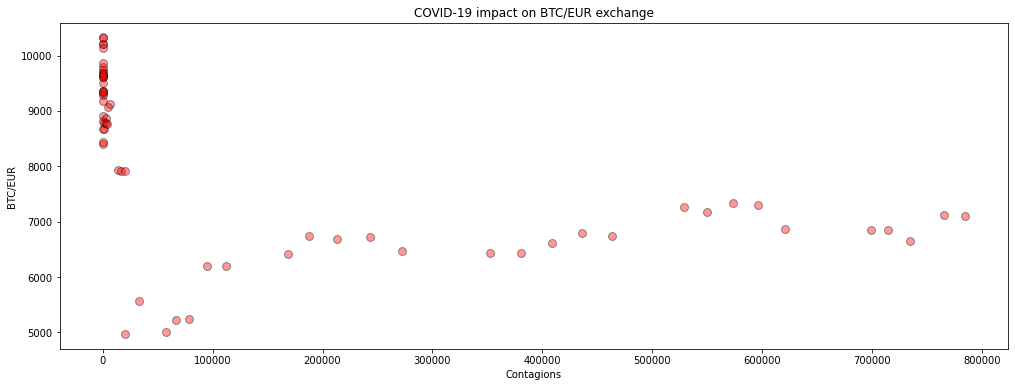

In [37]:
## COVID-19 vs BTC/EUR
plt.figure(figsize=(17,6))
plt.scatter(YTD_covid_impact_df.Eurozone, YTD_covid_impact_df.Close_BTC_EUR, label='BTC/EUR', s = 250,
            color='red',edgecolor='black',alpha=0.4, marker=".")
plt.xlabel('Contagions')
plt.ylabel('BTC/EUR')
plt.title('COVID-19 impact on BTC/EUR exchange')


Text(0, 0.5, 'USD/EUR')

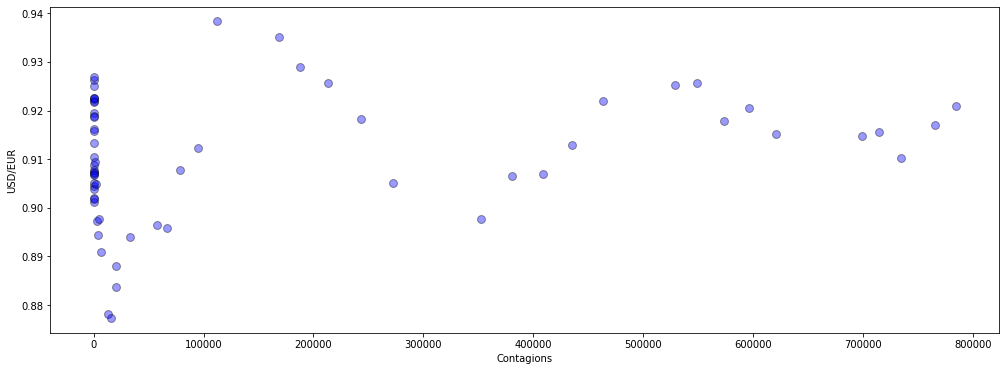

In [38]:
## COVID-19 vs USD/EUR
plt.figure(figsize=(17,6))
plt.scatter(YTD_covid_impact_df.Eurozone, YTD_covid_impact_df.Close_USD_EUR, label='USD/EUR', s = 250,
            color='blue',edgecolor='black',alpha=0.4, marker=".")
plt.xlabel('Contagions')
plt.ylabel('USD/EUR')

Here we are getting bit of a paradoxal result in the sense that by the plots it looks like covid-19's impact on the USD/EUR exchange would be stronger than on the Bitcoin price in EUR, but then the graphs don't show that same relationship so we decided to filter the data to extract those values that skew our results.

In [39]:
# Here we are getting rid of the data from the Covid-19 dataset until the cases where 25000 because that data was messing 
#with our results skewing the correlation to answers that didn't add up to our intuition.
crisis_covid_impact_df = covid_impact_df[covid_impact_df.Eurozone>=25000]
crisis_covid_impact_df.head()

,Date,US,Eurozone,US_d,Eurozone_d,Open_EUR_USD,High_EUR_USD,Low_EUR_USD,Close_EUR_USD,Open_BTC_EUR,High_BTC_EUR,Low_BTC_EUR,Close_BTC_EUR,Volume_BTC_EUR,Market_cap_BTC_EUR,Close_USD_EUR
51,2020-03-13,2179.0,33061.0,47.0,1506.0,1.118356,1.122133,1.106537,1.118493,5017.83,5838.11,4106.98,5563.71,7.415677e+10,1.016446e+11,0.89406
52,2020-03-14,2727.0,40212.0,54.0,1765.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,2020-03-15,3499.0,47369.0,63.0,2238.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,2020-03-16,4632.0,57258.0,85.0,2712.0,1.115959,1.123540,1.108869,1.115536,5385.23,5385.23,4575.36,5014.48,4.536803e+10,9.163348e+10,0.89643
55,2020-03-17,6421.0,66856.0,108.0,3281.0,1.116333,1.118906,1.095794,1.116321,5002.58,5371.35,4981.91,5225.63,3.862264e+10,9.549994e+10,0.89580


Text(0.5, 1.0, 'COVID-19 impact on USD/EUR exchange')

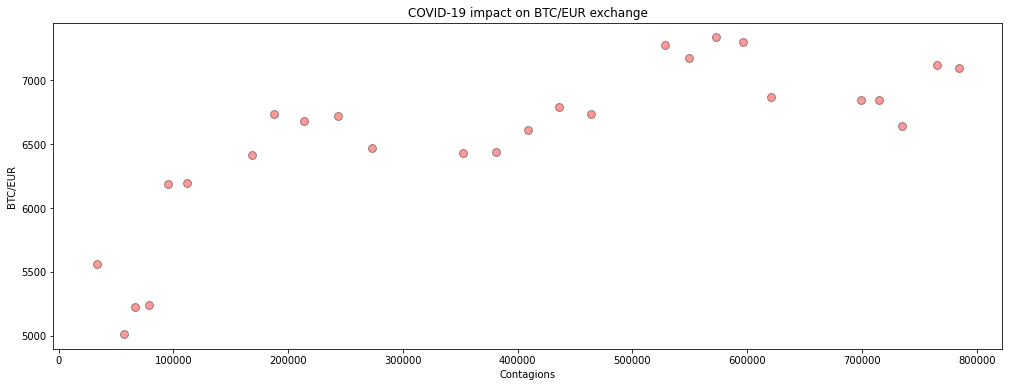

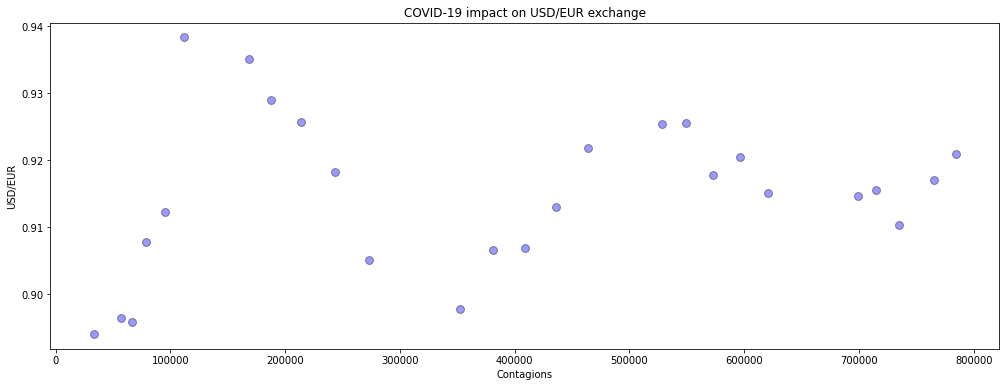

In [40]:
#Now we are plotting the same thing than above but without those extreme values
## COVID-19 vs BTC/EUR
plt.figure(figsize=(17,6))
plt.scatter(crisis_covid_impact_df.Eurozone, crisis_covid_impact_df.Close_BTC_EUR, label='BTC/EUR', s = 250,
            color='red',edgecolor='black',alpha=0.4, marker=".")
plt.xlabel('Contagions')
plt.ylabel('BTC/EUR')
plt.title('COVID-19 impact on BTC/EUR exchange')
plt.savefig('covid_BTC.png', dpi = 300, quality=100)
## COVID-19 vs USD/EUR
plt.figure(figsize=(17,6))
plt.scatter(crisis_covid_impact_df.Eurozone, crisis_covid_impact_df.Close_USD_EUR, label='USD/EUR', s = 250,
            color='blue',edgecolor='black',alpha=0.4, marker=".")
plt.xlabel('Contagions')
plt.ylabel('USD/EUR')
plt.title('COVID-19 impact on USD/EUR exchange')


From the plots above we can see much more clearly that the strengh of the correlation between covid-19 cases and the Bitcoin price is quite stronger than the correlation.

We can see that the price of the Bitcoin in EUR increses more than the USD/EUR exchange when the number of cases increase.

This could explain why in times like this there are people that are betting on the Bitcoin to be a better store of value than the EURO. It's clear that the fiat currncies are much more affected by external shocks such as this Covid-19 crisis that make the foundation of a country tremble.

To be sure about that we are going to build the correlations matrix again to see if after the filtering we get more conclusive results


In [41]:
#Creating the correlation matrix of the filtered data
coor_mat_this_year = crisis_covid_impact_df.corr()
coor_mat_this_year

,US,Eurozone,US_d,Eurozone_d,Open_EUR_USD,High_EUR_USD,Low_EUR_USD,Close_EUR_USD,Open_BTC_EUR,High_BTC_EUR,Low_BTC_EUR,Close_BTC_EUR,Volume_BTC_EUR,Market_cap_BTC_EUR,Close_USD_EUR
US,1.000000,0.981081,0.971204,0.996349,-0.180953,-0.336761,-0.023406,-0.184275,0.731448,0.675468,0.701274,0.691312,-0.415625,0.696385,0.175240
Eurozone,0.981081,1.000000,0.916216,0.993703,-0.216915,-0.383529,-0.046732,-0.220029,0.808792,0.754582,0.793905,0.775906,-0.477124,0.780346,0.210243
US_d,0.971204,0.916216,1.000000,0.950718,-0.155639,-0.295833,-0.027022,-0.159066,0.617068,0.564639,0.586308,0.581119,-0.366116,0.586583,0.151139
Eurozone_d,0.996349,0.993703,0.950718,1.000000,-0.199303,-0.360248,-0.035363,-0.202604,0.771022,0.715139,0.746223,0.732406,-0.442074,0.737216,0.193208
Open_EUR_USD,-0.180953,-0.216915,-0.155639,-0.199303,1.000000,0.938405,0.889315,0.999589,-0.501627,-0.614927,-0.556374,-0.585013,-0.010672,-0.582608,-0.999393
High_EUR_USD,-0.336761,-0.383529,-0.295833,-0.360248,0.938405,1.000000,0.894778,0.935639,-0.573365,-0.705982,-0.650163,-0.695760,0.065340,-0.694194,-0.932259
Low_EUR_USD,-0.023406,-0.046732,-0.027022,-0.035363,0.889315,0.894778,1.000000,0.881488,-0.227013,-0.408040,-0.354583,-0.401510,-0.049537,-0.398821,-0.881103
Close_EUR_USD,-0.184275,-0.220029,-0.159066,-0.202604,0.999589,0.935639,0.881488,1.000000,-0.507433,-0.614358,-0.559212,-0.583679,-0.007952,-0.581323,-0.999885
Open_BTC_EUR,0.731448,0.808792,0.617068,0.771022,-0.501627,-0.573365,-0.227013,-0.507433,1.000000,0.921083,0.962433,0.895969,-0.463303,0.897177,0.498665
High_BTC_EUR,0.675468,0.754582,0.564639,0.715139,-0.614927,-0.705982,-0.408040,-0.614358,0.921083,1.000000,0.915264,0.968687,-0.219519,0.968661,0.607194


In [42]:
print("Covid-19 cases correlation with the USD/EUR exchange is: ", coor_mat_this_year.Eurozone[14])
print("Covid-19 cases correlation with Bitcoin price in EUR is: ", coor_mat_this_year.Eurozone[11])

Covid-19 cases correlation with the USD/EUR exchange is:  0.21024342453783873
Covid-19 cases correlation with Bitcoin price in EUR is:  0.7759057567705124


'''plt.scatter(crisis_covid_impact_df['Eurozone'], crisis_covid_impact_df['Close_BTC_EUR'], color='red')
plt.title('Eurozone cases vs Close_BTC_EUR', fontsize=14)
plt.xlabel('Covid-19 cases', fontsize=14)
plt.ylabel('Bitcoin price in EUR', fontsize=14)
plt.grid(True)
plt.show()'''

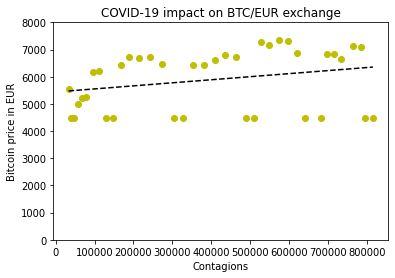

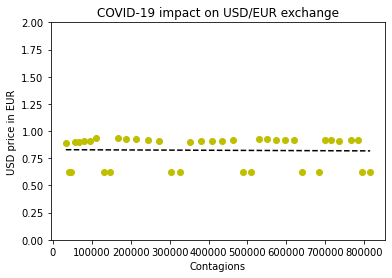

<Figure size 30000x30000 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [53]:
#Covid-19 correlation with BTC/EUR
x = crisis_covid_impact_df['Eurozone'].values
y = crisis_covid_impact_df['Close_BTC_EUR'].values
y_nan = np.isnan(y)
y[y_nan] = 0
col_mean = np.nanmean(y, axis=0)
y = np.where(np.equal(y, 0), col_mean, y)
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y
plt.xlabel('Contagions')
plt.ylabel('Bitcoin price in EUR')
plt.title('COVID-19 impact on BTC/EUR exchange')
plt.plot(x,y, 'yo', x, poly1d_fn(x), '--k')
plt.ylim(0, 8000)
plt.show()
#Covid-19 correlation with USD/EUR
x = crisis_covid_impact_df['Eurozone'].values
y = crisis_covid_impact_df['Close_USD_EUR'].values
y_nan = np.isnan(y)
y[y_nan] = 0
col_mean = np.nanmean(y, axis=0)
y = np.where(np.equal(y, 0), col_mean, y)
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y
plt.xlabel('Contagions')
plt.ylabel('USD price in EUR')
plt.title('COVID-19 impact on USD/EUR exchange')
plt.plot(x,y, 'yo', x, poly1d_fn(x), '--k')
plt.ylim(0, 2)
plt.figure(figsize=(100,100), dpi=300)
plt.figure()
plt.show()




From the linear regression lines from above we can now clearly see that the Covid-19 crisis has made the Bitcoin price to increase, making it a good moment to invest in it. 

# So...Is Bitcoin a store of value?

## There's two characteristics a store of value has to have:
- Supply is finite: The supply of it can’t be artificially boosted.
- Retaining value: A store of value is an asset that’s capable of retaining value over time.

###  The bitcoin agrees completely with the first condition as the number of bitcoins is a finit one.

### But the second condition is harder to satisfy, because it depends on two things:
1. The currency of your savings
2. The economic circumstances of the specific moment.

## 1. The currency of your savings
### If your currency is volatile in itself (like the Venezuelan Bolivar), bitcoin can be a good store of value because it has more stability and it's more worth that your fiat currency over time.
### But if your currency is a stable one (I.E. USD or EUR) bitcoin wouldn't be a good store of value in normal circumstances because of its higher volatility.

## 2. The economic circumstances of the specific moment.
### As we said above, if your currency is a strong one and the circumstances are normal, Bitcoin wouldn't be a good store of value.
### Although... what if the economy has taken an external shock?
### Then the value of its currency will be much more afected by the shock. Making the bitcoin a more stable currency. Therefore th Bitcoin becomes a better store of value.
### Nevertheless, we also think that if the shock is big enough to bring us to a post-apocalyptic scenario, we assume Bitcoin's value would drop to 0 very fast, so the risk is there.

Now we can see that the correlations tell us that the Covid-19 crisis has impacted much more to the Bitcoin price than to the
USD/EUR exchange. In other words, the more cases a the Eurozone has, the higher the Bitcoin price gets. Therefore, we can conclude that nowadays it makes sense to use Bitcoin as a _store of value_.